In [1]:
from pathlib import Path
from pathlib import *
import pandas as pd
import re
from random import randint
import spacy
from time import time
import matplotlib.pyplot as plt
import gensim
import gensim.corpora as corpora
from pprint import pprint
from gensim.models import TfidfModel
from gensim.models import CoherenceModel
from gensim.test.utils import datapath
from gensim import  models
nlpd = spacy.load("da_core_news_lg")
import os

## Topic model over 00'ernes eu-debat

In [2]:
path = "../../Folketingstidende/Hele/"
dir_path = Path(f"{path}")
csv_files = list(dir_path.glob("*.csv"))

In [3]:
csv_files.sort()
csv_files[0:5]

[PosixPath('../../Folketingstidende/Hele/19531.csv'),
 PosixPath('../../Folketingstidende/Hele/19541.csv'),
 PosixPath('../../Folketingstidende/Hele/19551.csv'),
 PosixPath('../../Folketingstidende/Hele/19561.csv'),
 PosixPath('../../Folketingstidende/Hele/19562.csv')]

Jeg finder nu de filer der handler om 00'erne

In [4]:
csv_files[61:]

[PosixPath('../../Folketingstidende/Hele/20001.csv'),
 PosixPath('../../Folketingstidende/Hele/20011.csv'),
 PosixPath('../../Folketingstidende/Hele/20012.csv'),
 PosixPath('../../Folketingstidende/Hele/20021.csv'),
 PosixPath('../../Folketingstidende/Hele/20031.csv'),
 PosixPath('../../Folketingstidende/Hele/20041.csv'),
 PosixPath('../../Folketingstidende/Hele/20042.csv'),
 PosixPath('../../Folketingstidende/Hele/20051.csv'),
 PosixPath('../../Folketingstidende/Hele/20061.csv'),
 PosixPath('../../Folketingstidende/Hele/20071.csv'),
 PosixPath('../../Folketingstidende/Hele/20072.csv'),
 PosixPath('../../Folketingstidende/Hele/20081.csv')]

In [5]:
Folketingstaler_i_00erne = {}
for fil in csv_files[61:]:
    if str(fil)[-9:-5] in Folketingstaler_i_00erne:
        folketingsår = pd.read_csv(fil ,sep=';', encoding = "latin1")
        taler = folketingsår["indhold"]
        for tale in taler:
            Folketingstaler_i_00erne[str(fil)[-9:-5]].append(tale)
    else:
        folketingsår = pd.read_csv(fil ,sep=';', encoding = "latin1")
        taler = folketingsår["indhold"]
        Folketingstaler_i_00erne[str(fil)[-9:-5]] = []
        for tale in taler:
            Folketingstaler_i_00erne[str(fil)[-9:-5]].append(tale)

In [6]:
def FT_taler(indhold):
    talere = []
    tale = []
    parti = []
    Partier_i_folketinget = ["(A)", "(SF)", "(S)", "(RV)", "(KF)", "(V)", "(FP)", "(CD)", "(VS)",
                             "(KrF)", "(DR)", "(UP)", "(Grønl.)", "(Fær.)", "(DF)", "(EL)"]
    for index in range(len(indhold)):
        sentence = indhold[index]
        if len(re.findall("(^.{1,50} \([A-Z]+\)[ ]*:|^.{1,50} \(KrF\)[ ]*:|^.{1,50} \(Grønl.\)[ ]*:|^.{1,50} \(Fær.\)[ ]*:)", sentence)) > 0: #Tjekker om det er et menigt medlem
            if len(re.findall("(\([A-Z]+\)|\(KrF\)|\(Grønl.\)|\(Fær.\))", sentence)) < 2:    
                if len(re.findall("Ny stedf.", sentence)) > 0:
                    pass
                elif len(re.findall("Udtræder:", sentence)) > 0:
                    pass
                elif len(re.findall("Nyt medl", sentence)) > 0:
                    pass
                elif len(re.findall(" af", sentence.lower())) > 0:
                    pass
                elif re.findall("(\([A-Z]+\)|\(KrF\)|\(Grønl.\)|\(Fær.\))", sentence)[0] in Partier_i_folketinget:
                    if len(sentence) <= 35:
                        talere.append(sentence)
                        parti.append(re.findall("(\([A-Z]+\)|\(KrF\)|\(Grønl.\)|\(Fær.\))", sentence)[0])
                        tale.append("")
                    else: #Tager højde for læsefejl!
                        lang_taler = re.split("(^.{1,50} \([A-Z]+\)|^.{1,50} \(KrF\)|^.{1,50} \(Grønl.\)|^.{1,50} \(Fær.\))", sentence)
                        talere.append(lang_taler[-2])
                        parti.append(re.findall("(\([A-Z]+\)|\(KrF\)|\(Grønl.\)|\(Fær.\))", lang_taler[-2])[0])
                        tale.append(lang_taler[-1])
                else:
                    if len(tale) >= 1:
                        tale[-1] = tale[-1] + " " + sentence
            else: #ellers er det en tale
                if len(tale) >= 1:
                    tale[-1] = tale[-1] + " " + sentence
                #if len(re.findall("(\([A-Z]+\)|\(KrF\))", sentence)) < 2:
        elif len(re.findall("(^.{1,50} \([A-Z]+\)|^.{1,50} \(KrF\)|^.{1,50} \(Grønl.\)|^.{1,50} \(Fær.\))", sentence)) > 0 and re.match("^Af ", sentence):
            talere.append(sentence)
            parti.append(re.findall("(\([A-Z]+\)|\(KrF\)|\(Grønl.\)|\(Fær.\))", sentence)[0])
            tale.append("")
        elif len(re.findall("(^.{1,50} \([A-Z]+\):|.{1,50} \(KrF\):)", sentence)) > 0:
            if len(sentence) > 35:
                if len(re.findall("(\([A-Z]+\)|\(KrF\))", sentence)) < 2:
                    if len(re.findall("Ny stedf.", sentence)) > 0:
                        pass
                    elif len(re.findall("Udtræder:", sentence)) > 0:
                        pass
                    elif len(re.findall("Nyt medl", sentence)) > 0:
                        pass
                    elif len(re.findall(" af", sentence.lower())) > 0:
                        pass
                    elif re.findall("(\([A-Z]+\)|\(KrF\))", sentence)[0] in Partier_i_folketinget:
                        problem_menigt = re.split("(^.{1,50} \([A-Z]+\):|.{1,50} \(KrF\):)", sentence.lower())
                        talere.append(problem_menigt[-2])
                        parti.append("problem")
                        tale.append(problem_menigt[-1])
                    else:
                        if len(tale) >= 1:
                            tale[-1] = tale[-1] + " " + sentence
                else:
                    if len(tale) >= 1:
                        tale[-1] = tale[-1] + " " + sentence
            else:
                if len(tale) >= 1:
                    tale[-1] = tale[-1] + " " + sentence
        elif sentence.lower() == "formanden" or sentence.lower() == "formanden:": #tjekker om det er formanden der taler
            talere.append("formanden")
            parti.append("Formanden")
            tale.append("")
        elif re.search("næstformand \(\w*\):$", sentence.lower()) or re.search("næstformand \(\w* \w*\):$", sentence.lower()):
            talere.append(sentence.lower())
            parti.append("næstformanden")
            tale.append("")
        elif len(sentence) < 100: #Tjekker om det er en minister der taler
            if len(re.findall("\w*minister[\w ]*\(([\w-]*|[\w ]*)\)", sentence.lower())) > 0:
                talere.append(sentence)
                parti.append("Regeringen")
                tale.append("")
            else:
                if len(tale) >= 1:
                    tale[-1] = tale[-1] + " " + sentence
        elif len(sentence) >= 100:
            if len(re.findall("\w*minister[\w ]*\(([\w-]*|[\w ]*)\):", sentence.lower())) > 0:
                tale_med_minister = re.split("\w*minister[\w ]*\(([\w-]*|[\w ]*)\):", sentence.lower())
                talere.append(tale_med_minister[-2])
                parti.append("Regeringen")
                tale.append(tale_med_minister[-1])
            else:
                if len(tale) >= 1:
                    tale[-1] = tale[-1] + " " + sentence
        elif len(re.findall("[1-9]{1,5} [1-9]{1,2}/[1-9]{1,2}", sentence.lower()))  > 0: #tilføjet til at fange headers på sider
            if len(sentence) < 170:
                pass
            else:
                if len(tale) >= 1:
                    tale[-1] = tale[-1] + " " + sentence
        elif len(re.findall("^[1-9]{1,2}/[1-9]{1,2}", sentence.lower())) > 0: 
            if len(sentence) < 170:
                pass
            else:
                if len(tale) >= 1:
                    tale[-1] = tale[-1] + " " + sentence
        elif re.fullmatch("\[.{1,100}\]", sentence.lower()):
            pass
        elif re.fullmatch("[1-9]{1,10}", sentence.lower()):
            pass
        else:
            if len(tale) >= 1:
                tale[-1] = tale[-1] + " " + sentence
    return tale, talere, parti

In [7]:
Folketingsår_opdelt_per_taler_00erne = {}
problemer = {}
for år in Folketingstaler_i_00erne:
    indhold = Folketingstaler_i_00erne[år]
    år_tale, år_talere, år_parti = FT_taler(indhold)
    Folketingsår_opdelt_per_taler_00erne[år] = []
    Folketingsår_opdelt_per_taler_00erne[år].append(år_tale)
    Folketingsår_opdelt_per_taler_00erne[år].append(år_talere)
    Folketingsår_opdelt_per_taler_00erne[år].append(år_parti)

## Lissabon og Nice i tekst

Jeg starter med Nice-traktaten

In [8]:
eu_ord_2 = [" eu ", " ef ", "europæiske fællesskab", "europæiske union", "fællesmarkedet", "ømu", " eu-", " ef-"]
nice_taler = []
nice_taler_ikke_eu = []
for år in Folketingsår_opdelt_per_taler_00erne:
    for sentence in Folketingsår_opdelt_per_taler_00erne[år][0]:
        if len(re.findall("nice", sentence.lower())) > 0:
            total = 0
            for ord_type in eu_ord_2:
                total += len(re.findall(ord_type, sentence.lower()))
            if total == 0:
                nice_taler_ikke_eu.append(sentence.lower())
            else:        
                nice_taler.append((år, sentence.lower()))

In [9]:
len(nice_taler_ikke_eu)

365

Der er altsp 118 folketingstaler hvor "Nice" indgår uden de ovenstående ord.

Jeg fjerner nu dem der også handler om traktater.

In [10]:
nice_taler_ikke_eu_ikke_traktat = []
for sentence in nice_taler_ikke_eu:
    if len(re.findall("nicetraktat", sentence.lower())) > 0 or len(re.findall("traktat", sentence.lower())) > 0:
        pass
    else:
        nice_taler_ikke_eu_ikke_traktat.append(sentence)

In [11]:
len(nice_taler_ikke_eu_ikke_traktat)

98

In [12]:
nice_taler_ikke_eu_ikke_traktat

[' jeg er ikke overrasket, men må konstatere, at dansk folkeparti altid kun hører, hvad de vil høre. og jeg vil anbefale, at de fremover lytter efter. jeg skal gerne gentage, hvad jeg sagde i min tale: dialog skal være omdrejningspunktet, når 62 torsdag den 5. oktober 2000 (r 1) der skal findes løsninger i demokratiet. det, vi var vidner til i københavns gader i går, var derfor helt uacceptabelt. det, jeg siger, er, at vi lever i et demokrati. det bygger på dialog og ikke på bøller. det er helt uacceptabelt, lige meget hvem det er, der laver sådan noget ballade. om det er fodboldbøller, om det er rockere, eller om det er palæstinensere, så vil vi ikke acceptere det. vi vil ikke finde os i det. det var det, jeg sagde. og jeg kan ikke forstå, at hr. kristian thulesen dahl overhovedet kunne misforstå det. men o.k., det må jeg jo så tage til efterretning. angående folkeafstemningen i torsdags så synes jeg, at modstanderne, i hvert fald dansk folkeparti, skal passe på, at de ikke tager pate

In [13]:
nice_taler_ikke_eu_ikke_traktat_ikke_folkeafstemning = []
for sentence in nice_taler_ikke_eu_ikke_traktat:
    if len(re.findall("folkeafstemning", sentence.lower())) > 0:
        pass
    else:
        nice_taler_ikke_eu_ikke_traktat_ikke_folkeafstemning.append(sentence)

In [14]:
len(nice_taler_ikke_eu_ikke_traktat_ikke_folkeafstemning)

88

In [15]:
nice_taler_ikke_eu_ikke_traktat_ikke_folkeafstemning

[' debatten her af forslaget til vedtagelse og det møde, der er indkaldt til i næste uge, skal faktisk opfattes som en udstrakt hånd til at tage en debat. der står jo netop i vedtagelsen, at der skal holdes tæt kontakt med folketingets partier og europaudvalget, og der skal også drøftes et lidt længere perspektiv, altså: hvad skal der ske efter nice med hensyn til samarbejdet mellem medlemslandene og europas globale indsats? jeg synes faktisk, det er ret flot og overordnet. vores holdning ligger fast. vi vil ikke medvirke til ting, der direkte eller indirekte påvirker vores velfærdspolitik eller vores arbejdsmarkedsmodel. det er socialdemokratiets holdning. det har vi sådan set ment hele tiden. det er det, vi hele tiden har sagt. vi vil ikke medvirke til noget, der på nogen måde kan bringe dansk velfærd i fare. det synes jeg bør være rimelig klart, både efter debatten her og også efter det, der står i forslaget til vedtagelse. (kort bemærkning).',
 ' jeg synes, det er tydeligt at høre,

In [16]:
nice_taler_ikke_eu_ikke_traktat_ikke_folkeafstemning_ikke_topmøde = []
for sentence in nice_taler_ikke_eu_ikke_traktat_ikke_folkeafstemning:
    if len(re.findall("nicetopmøde", sentence.lower())) > 0 or len(re.findall("topmøde", sentence.lower())) > 0:
        pass
    else:
        nice_taler_ikke_eu_ikke_traktat_ikke_folkeafstemning_ikke_topmøde.append(sentence)

In [17]:
len(nice_taler_ikke_eu_ikke_traktat_ikke_folkeafstemning_ikke_topmøde)

78

In [18]:
nice_taler_ikke_eu_ikke_traktat_ikke_folkeafstemning_ikke_topmøde

[' debatten her af forslaget til vedtagelse og det møde, der er indkaldt til i næste uge, skal faktisk opfattes som en udstrakt hånd til at tage en debat. der står jo netop i vedtagelsen, at der skal holdes tæt kontakt med folketingets partier og europaudvalget, og der skal også drøftes et lidt længere perspektiv, altså: hvad skal der ske efter nice med hensyn til samarbejdet mellem medlemslandene og europas globale indsats? jeg synes faktisk, det er ret flot og overordnet. vores holdning ligger fast. vi vil ikke medvirke til ting, der direkte eller indirekte påvirker vores velfærdspolitik eller vores arbejdsmarkedsmodel. det er socialdemokratiets holdning. det har vi sådan set ment hele tiden. det er det, vi hele tiden har sagt. vi vil ikke medvirke til noget, der på nogen måde kan bringe dansk velfærd i fare. det synes jeg bør være rimelig klart, både efter debatten her og også efter det, der står i forslaget til vedtagelse. (kort bemærkning).',
 ' jeg synes, det er tydeligt at høre,

Det eneste problem er nice og unicef.

Nu finder jeg lissabon:

In [19]:
eu_ord_2 = [" eu ", " ef ", "europæiske fællesskab", "europæiske union", "fællesmarkedet", "ømu", " eu-", " ef-"]
lissabon_taler = []
lissabon_taler_ikke_eu = []
for år in Folketingsår_opdelt_per_taler_00erne:
    for sentence in Folketingsår_opdelt_per_taler_00erne[år][0]:
        if len(re.findall("lissabon", sentence.lower())) > 0:
            total = 0
            for ord_type in eu_ord_2:
                total += len(re.findall(ord_type, sentence.lower()))
            if total == 0:
                lissabon_taler_ikke_eu.append(sentence.lower())
            else:        
                lissabon_taler.append((år, sentence.lower()))

In [20]:
len(lissabon_taler_ikke_eu)

276

In [21]:
lissabon_taler_ikke_eu

[' jf. den nuværende art. 137, stk. 2 sidste afsnit kan rådet vedtage foranstaltninger til fremme af samarbejdet mellem medlemslandene, gennem initiativer, der tager sigte på at opnå større viden, udvikle udvekslingen af information og gode erfaringer, fremme nytænkning og vurdere erfaringer, med det formål at bekæmpe social udstødelse. fsva. sidstnævnte er der følgelig ikke tale om nogen ny tilføjelse. det foreslås - jf. confer 4795 af 9. november 2000 - at der i samme bestemmelse skabes mulighed for fremme af samarbejdet mellem medlemsstater fsva. »udvikling og forbedring af social beskyttelse«. det præciseres, at denne bestemmelse ikke indebærer harmonisering af medlemsstaternes love og administrative bestemmelser. forslaget ligger i direkte forlængelse af det europæiske råds møde i lissabon i marts, hvor man besluttede at styrke den åbne koordinati- onsmetode, hvorefter samarbejde vedrørende social beskyttelse primært bygger på erfaringsudveksling og samarbejde mellem medlemslanden

Lissabon virker til at være om lissabontraktaten.

### Nu udvælges folketingstaler

In [22]:
EU_ord = [" eu ", " ef ", "europæiske fællesskab", "europæiske union", "fællesmarked", "ømu", "maastricht", 
          "amsterdamtraktaten", "eu-", "ef-", "edinburgh", "indre marked", "lissabon", "euro-", "euro "]

In [23]:
eu_taler_00erne = {}
for år in Folketingsår_opdelt_per_taler_00erne:
    #start = time()
    eu_tale_år = []
    eu_parti_år = []
    eu_taler_år = []
    for index in range(len(Folketingsår_opdelt_per_taler_00erne[år][0])):
        tale = Folketingsår_opdelt_per_taler_00erne[år][0][index]
        for ord_ in EU_ord:
            if len(re.findall(ord_, tale.lower())) > 0:
                eu_tale_år.append(tale)
                eu_parti_år.append(Folketingsår_opdelt_per_taler_00erne[år][1][index])
                eu_taler_år.append(Folketingsår_opdelt_per_taler_00erne[år][2][index])
                break
        if len(eu_tale_år) != 0:
            if eu_tale_år[-1] != tale:
                if len(re.findall("nice", tale.lower())) > 0:
                    if len(re.findall("unicef", tale.lower())) == 0:
                        eu_tale_år.append(tale)
                        eu_parti_år.append(Folketingsår_opdelt_per_taler_00erne[år][1][index])
                        eu_taler_år.append(Folketingsår_opdelt_per_taler_00erne[år][2][index])           
    eu_taler_00erne[år] = []
    eu_taler_00erne[år].append(eu_tale_år)
    eu_taler_00erne[år].append(eu_parti_år)
    eu_taler_00erne[år].append(eu_taler_år)

In [24]:
for år in eu_taler_00erne:
    print(f"{år}: {len(eu_taler_00erne[år][0])}")

2000: 2689
2001: 1940
2002: 2167
2003: 2434
2004: 2113
2005: 1321
2006: 1724
2007: 1775
2008: 1689


In [25]:
antal_taler_år = [len(eu_taler_00erne[år][0]) for år in eu_taler_00erne]
antal_taler_år

[2689, 1940, 2167, 2434, 2113, 1321, 1724, 1775, 1689]

In [26]:
Alle_taler = []
Alle_taler_år = []
Alle_taler_parti = []
Alle_taler_taler = []
for år in eu_taler_00erne:
    for index in range(len(eu_taler_00erne[år][0])):
        Alle_taler.append(eu_taler_00erne[år][0][index])
        Alle_taler_parti.append(eu_taler_00erne[år][1][index])
        Alle_taler_taler.append(eu_taler_00erne[år][2][index])
        Alle_taler_år.append(år)

In [27]:
nlpd = spacy.load("da_core_news_lg")

In [28]:
tekster_klar = []
fyldetegn = [",", ".", "(", ")", "?", "/", "!", ":", " ", "):", "-", "«", "»", "[", "]"]
stopord_fil = open('../../Folketingstidende/stopord.txt','r')
stopord = [word[:-1] for word in stopord_fil] + ["altså", "gå", "gerne", "tro", "faktisk", "gerne", "eu" "selvfølgelig", "dag"]

In [29]:
typer_spacy = []
for tegn in fyldetegn:
    tekst_nlpd = nlpd(tegn)
    for token in tekst_nlpd:
        if token.pos_ not in typer_spacy:
            typer_spacy.append(token.pos_)

In [30]:
typer_spacy.remove("PROPN")

In [31]:
typer_spacy

['PUNCT', 'X', 'SPACE', 'ADJ']

In [32]:
for år in eu_taler_00erne:
    #allowed_postags=['NOUN', 'ADJ', 'VERB']
    start = time()
    for tekst in eu_taler_00erne[år][0]:
        tale_spacy = nlpd(tekst.lower())
        #tokens = [str(token.lemma_).lower() for token in tale_spacy]
        tokens = [token for token in tale_spacy]
        tokens_uden_tegn = [str(token) for token in tokens if token.pos_ not in typer_spacy]
        #tokens_uden_stopord = [token for token in tokens_uden_tegn if token not in stopord]
        tekster_klar.append(tokens_uden_tegn)
    end = time()
    print(end-start)

439.0060591697693
301.16825914382935
205.45068311691284
241.21505522727966
219.63901019096375
183.0150420665741
355.8369081020355
281.914057970047
209.95975518226624


In [33]:
processed_data = []
for tekst in tekster_klar:
    str_tekst = [str(token) for token in tekst]
    processed_data.append(str_tekst)

In [34]:
bigram = gensim.models.Phrases(processed_data, min_count=5, threshold=100)

trigram = gensim.models.Phrases(bigram[processed_data], threshold=100)

bigram_mod = gensim.models.phrases.Phraser(bigram)

trigram_mod = gensim.models.phrases.Phraser(trigram)

In [35]:
def remove_stopwords(texts):
    return [[word for word in doc if word not in stopord] for doc in texts]
def create_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]
def create_trigrams(texts):
    [trigram_mod[bigram_mod[doc]] for doc in texts]
def lemmatize(texts, allowed_postags=['NOUN', 'ADJ', 'VERB']):
    texts_op = []
    start = time()
    for sent in texts:
        doc = nlpd(" ".join(sent))
        texts_op.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    end = time()
    print(end-start)
    return texts_op

In [36]:
#removing stopwords, creating bigrams and lemmatizing the text

data_wo_stopwords = remove_stopwords(processed_data)

data_bigrams = create_bigrams(data_wo_stopwords)

data_lemmatized = lemmatize(data_bigrams, allowed_postags=[ 'NOUN', 'ADJ', 'VERB', 'PROPN', 'ADV'])

649.4006338119507


In [37]:
stopwords_removed_2 = remove_stopwords(data_lemmatized) #Jeg prøver at sortere stopord fra igen

data_lemmatized = stopwords_removed_2

In [38]:
#gensim_dictionary = corpora.Dictionary(data_lemmatized)

texts = [text for text in data_lemmatized]

In [39]:
from random import shuffle
shuffle(texts)

In [40]:
#building a corpus for the topic model
gensim_dictionary = corpora.Dictionary(texts)

gensim_corpus = [gensim_dictionary.doc2bow(text) for text in texts]

In [41]:
gensim_dictionary.save("Dictionaries/2000_erne/07_11_22_flere_stopord")

In [46]:
gensim_dictionary = corpora.Dictionary.load("Dictionaries/2000_erne/07_11_22_flere_stopord")

## Cohenrence model

In [42]:
def compute_coherence_values(k):
    lda_model = gensim.models.ldamodel.LdaModel(corpus=gensim_corpus,
                                           id2word=gensim_dictionary,
                                           num_topics=k, 
                                           random_state=100,
                                           chunksize=100,
                                           passes=10,
                                           alpha="auto")
    
    coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=gensim_dictionary, coherence='c_v')
    return coherence_model_lda.get_coherence()

In [43]:
min_topics = 10
max_topics = 35
step_size = 1
topics_range = range(min_topics, max_topics, step_size)

#empty dataframe
model_results = {'Topics': [],
                 'Coherence': []
                }

# iterate through number of topics
for k in topics_range:
    print(k)
    # get the coherence score for the given topics
    cv = compute_coherence_values(k=k)
    # Save the model results
    model_results['Topics'].append(k)
    model_results['Coherence'].append(cv)

10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34


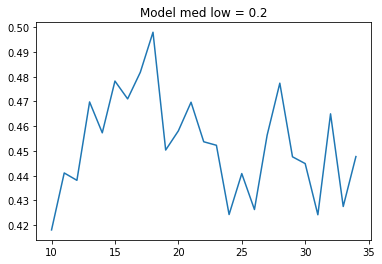

In [44]:
fig, ax = plt.subplots()
ax.plot(model_results["Topics"], model_results['Coherence'])
ax.set_title("Model med low = 0.2")
fig.savefig("plots/2000_erne/Coherence_score_07_11_22_flere_stopord")

In [45]:
coherence_best = [coherence for coherence in model_results['Coherence']]
coherence_best.sort(reverse = True)

In [46]:
for top_coherence in coherence_best[0:5]:
    number_topics = model_results["Topics"][model_results['Coherence'].index(top_coherence)]
    print(number_topics)
    lda_model = gensim.models.ldamodel.LdaModel(
        corpus=gensim_corpus, id2word=gensim_dictionary, num_topics=number_topics, random_state=100, 
        update_every=1, chunksize=100, passes=10, alpha='auto', per_word_topics=True
    )
    lda_model.save(f"Modeller/2000_erne/07_11_2022_flere_stopord/Model_{number_topics}_topics")

18
17
15
28
16


In [44]:
lda_model = gensim.models.ldamodel.LdaModel.load("Modeller/2000_erne/07_11_2022_flere_stopord/Model_15_topics")
pprint(lda_model.print_topics(-1))

[(0,
  '0.060*"fiskeri" + 0.032*"bilag" + 0.023*"nævn" + 0.023*"havn" + '
  '0.022*"skriftlig" + 0.020*"meddelt_mig" + 0.018*"forespørgselsdebat" + '
  '0.017*"søren_krarup" + 0.016*"fisker" + 0.015*"jensen"'),
 (1,
  '0.066*"kommune" + 0.030*"uddannelse" + 0.018*"institution" + 0.017*"andel" '
  '+ 0.015*"barn" + 0.014*"redegørelse_r" + 0.014*"amt" + 0.012*"antal" + '
  '0.012*"opgave" + 0.011*"samle"'),
 (2,
  '0.079*"tyrkiet" + 0.073*"rusland" + 0.049*"europarådet" + '
  '0.033*"tjetjenien" + 0.033*"optagelse" + 0.027*"nato" + 0.026*"bulgarien" + '
  '0.025*"rumænien" + 0.023*"medlem" + 0.023*"medlemskab"'),
 (3,
  '0.053*"statsminister" + 0.051*"forslag" + 0.050*"behandling" + 0.046*"nr." '
  '+ 0.027*"lov" + 0.024*"folketing" + 0.021*"sf" + 0.021*"fremsætte" + '
  '0.020*"medlem" + 0.020*"lovforslag"'),
 (4,
  '0.055*"spørgsmål" + 0.042*"minister" + 0.024*"svar" + 0.021*"sag" + '
  '0.020*"kommission" + 0.018*"oplyse" + 0.017*"s" + 0.014*"forbindelse" + '
  '0.012*"vurdering" + 0.

### Undersøger disse topics:

In [39]:
år_2000erne = [str(2000+i) for i in range(9)]
år_2000erne

['2000', '2001', '2002', '2003', '2004', '2005', '2006', '2007', '2008']

In [40]:
folketingsår = ["0" + str(i) + "/" + "0" + str(i + 1) for i in range(9)]
folketingsår

['00/01',
 '01/02',
 '02/03',
 '03/04',
 '04/05',
 '05/06',
 '06/07',
 '07/08',
 '08/09']

In [41]:
def topic_counter(data_lemmatized, topic_number):
    topics_subject = []
    topics_subject_sand = []
    for index in range(len(data_lemmatized)):
        bow = gensim_dictionary.doc2bow(data_lemmatized[index])
        eu_tale_topic_distribution = lda_model.get_document_topics(bow)
        for topic, sand in eu_tale_topic_distribution:
            if topic == topic_number:
                topics_subject.append(index)
                topics_subject_sand.append(sand)
    return topics_subject, topics_subject_sand

In [42]:
def year_counter(topics_subject):
    year_datapoints = [Alle_taler_år[i] for i in topics_subject]
    year_numbers = []
    for år in år_2000erne:
        year_numbers.append(year_datapoints.count(år))
    return year_numbers

(0.0, 1.1)

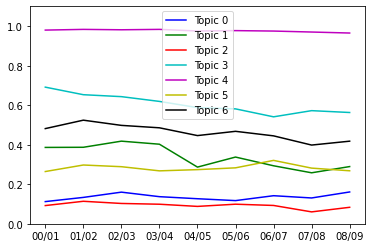

In [73]:
colors = ["b", "g", "r", "c", "m", "y", "k"]
fig, ax = plt.subplots()
for topic_number in range(7):
    topics, topics_sand = topic_counter(data_lemmatized, topic_number)
    topics_count = year_counter(topics)
    andel = [topics_count[i]/antal_taler_år[i] for i in range(9)]
    ax.plot(folketingsår, andel, label=f'Topic {topic_number}', color = colors[topic_number])
ax.legend()
ax.set_ylim([0, 1.1])

(0.0, 1.1)

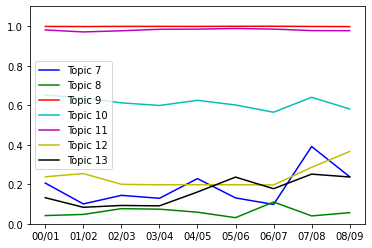

In [74]:
colors = ["b", "g", "r", "c", "m", "y", "k"]
fig, ax = plt.subplots()
for topic_number in range(7,14):
    topics, topics_sand = topic_counter(data_lemmatized, topic_number)
    topics_count = year_counter(topics)
    andel = [topics_count[i]/antal_taler_år[i] for i in range(9)]
    ax.plot(folketingsår, andel, label=f'Topic {topic_number}', color = colors[topic_number%7])
ax.legend()
ax.set_ylim([0, 1.1])

(0.0, 1.1)

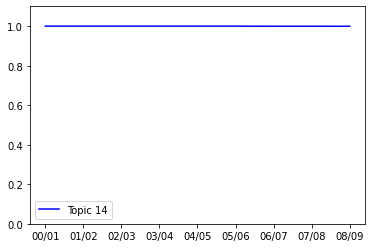

In [75]:
colors = ["b", "g", "r", "c", "m", "y", "k"]
fig, ax = plt.subplots()
for topic_number in range(14,15):
    topics, topics_sand = topic_counter(data_lemmatized, topic_number)
    topics_count = year_counter(topics)
    andel = [topics_count[i]/antal_taler_år[i] for i in range(9)]
    ax.plot(folketingsår, andel, label=f'Topic {topic_number}', color = colors[topic_number%7])
ax.legend()
ax.set_ylim([0, 1.1])

(0.0, 1.1)

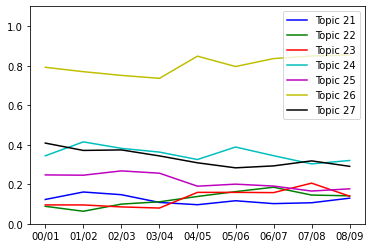

In [62]:
colors = ["b", "g", "r", "c", "m", "y", "k"]
fig, ax = plt.subplots()
for topic_number in range(21,28):
    topics, topics_sand = topic_counter(data_lemmatized, topic_number)
    topics_count = year_counter(topics)
    andel = [topics_count[i]/antal_taler_år[i] for i in range(9)]
    ax.plot(folketingsår, andel, label=f'Topic {topic_number}', color = colors[topic_number%7])
ax.legend()
ax.set_ylim([0, 1.1])

### 0 Undersøgelse af topic 0

In [59]:
topics_stof = []
topics_stof_sand = []
for index in range(len(data_lemmatized)):
    bow = gensim_dictionary.doc2bow(data_lemmatized[index])
    eu_tale_topic_distribution = lda_model.get_document_topics(bow)
    for topic, sand in eu_tale_topic_distribution:
        if topic == 0:
            topics_stof.append(index)
            topics_stof_sand.append(sand)
len(topics_stof)

2414

In [60]:
topics_stof_år = [Alle_taler_år[i] for i in topics_stof]
topics_stof_antal_taler_00_eren = []

for år in år_2000erne:
    topics_stof_antal_taler_00_eren.append(topics_stof_år.count(år))
topics_stof_andel = [topics_stof_antal_taler_00_eren[i]/antal_taler_år[i] for i in range(9)]

In [61]:
sand_stof_sort = [sand for sand in topics_stof_sand]
sand_stof_sort.sort(reverse = True)

In [62]:
best_sand = topics_stof_sand .index(sand_stof_sort[10])
best_sand_tale = topics_stof[best_sand]
print(Alle_taler_år[best_sand_tale])
print(Alle_taler_parti[best_sand_tale])
Alle_taler[best_sand_tale]

2007
Morten Messerschmidt (DF):


' Jeg mener, at det er grus, man kaster i maskineriet. Men jeg vil i øvrigt gerne tage noget tilbage, fordi hvis jeg har sagt, at det, som hr. Michael Aastrup Jensen sagde, var godt - jeg tror endda, jeg kom til at sige alvidenhed - så tror jeg næsten, man skal ændre det til uvidenhed. For sagen er altså, at det, hr. Michael Aastrup Jensen netop har sagt, er kategorisk forkert. Det er fuldstændig rigtigt, at Lissabontraktaten endnu ikke er trådt i kraft, og dermed har charteret endnu ikke fået den retskraft, som Lissabontraktaten skal give det, men EF-Domstolen afsiger jo allerede domme med henvisning til charteret. Disse domme er afsagt med henvisning til charteret, og dermed er alt det, som hr. Michael Aastrup Jensen står og siger, jo faldet fra hinanden. Charteret tages allerede til indtægt for den juridiske retstilstand i EU, og derfor kan man jo overhovedet ikke sige som hr. Michael Aastrup Jensen, nemlig at charteret ikke har noget med det her at gøre. Jo, det har det! Og hvis hr

In [71]:
best_sand_tale

0.47244698

### Topic 7 om folkeafstemninger:

In [47]:
topics_folkeafstemning = []
topics_folkeafstemning_sand = []
for index in range(len(data_lemmatized)):
    bow = gensim_dictionary.doc2bow(data_lemmatized[index])
    eu_tale_topic_distribution = lda_model.get_document_topics(bow)
    for topic, sand in eu_tale_topic_distribution:
        if topic == 7:
            topics_folkeafstemning.append(index)
            topics_folkeafstemning_sand.append(sand)
len(topics_folkeafstemning)

3296

In [48]:
topics_folkeafstemning_år = [Alle_taler_år[i] for i in topics_folkeafstemning]
topics_folkeafstemning_antal_taler_2000eren = []

for år in år_2000erne:
    topics_folkeafstemning_antal_taler_2000eren.append(topics_folkeafstemning_år.count(år))
topics_folkeafstemning_andel = [topics_folkeafstemning_antal_taler_2000eren[i]/antal_taler_år[i] for i in range(9)]

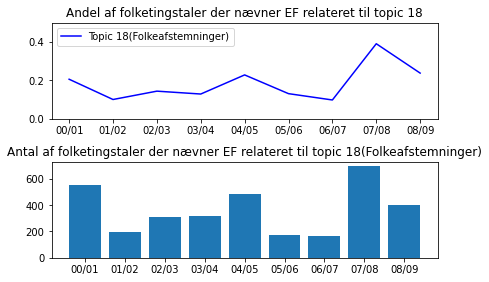

In [49]:
fig, (ax1, ax2) = plt.subplots(2, 1)
ax1.set_title("Andel af folketingstaler der nævner EF relateret til topic 7")
ax1.plot(folketingsår, topics_folkeafstemning_andel, color = "b", label= "Topic 7(Folkeafstemninger)")
ax2.set_title("Antal af folketingstaler der nævner EF relateret til topic 7(Folkeafstemninger)")
ax2.bar(folketingsår, topics_folkeafstemning_antal_taler_2000eren)
ax1.set_ylim([0, 0.5])
ax1.legend()
fig.tight_layout(pad=1.0)
fig.savefig("plots/2000_erne/Andel_af_folketingstaler_der_nævner_EU_relateret_til_topic_7")

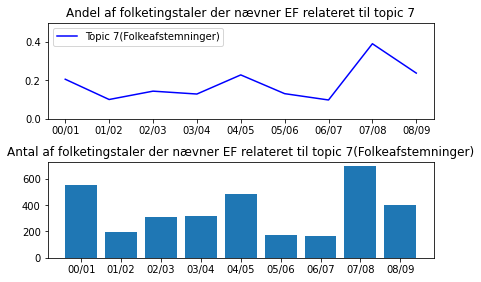

In [50]:
fig, (ax1, ax2) = plt.subplots(2, 1)
ax1.set_title("Andel af folketingstaler der nævner EF relateret til topic 7")
ax1.plot(folketingsår, topics_folkeafstemning_andel, color = "b", label= "Topic 7(Folkeafstemninger)")
ax2.set_title("Antal af folketingstaler der nævner EF relateret til topic 7(Folkeafstemninger)")
ax2.bar(folketingsår, topics_folkeafstemning_antal_taler_2000eren)
ax1.set_ylim([0, 0.5])
ax1.legend()
fig.tight_layout(pad=1.0)
fig.savefig("plots/2000_erne/Andel_af_folketingstaler_der_nævner_EU_relateret_til_topic_7")

In [51]:
topics_folkeafstemning_antal_taler_2000eren

[554, 195, 312, 314, 483, 173, 169, 694, 402]

### Landbrug topic 8

In [52]:
topics_landbrug = []
topics_landbrug_sand = []
for index in range(len(data_lemmatized)):
    bow = gensim_dictionary.doc2bow(data_lemmatized[index])
    eu_tale_topic_distribution = lda_model.get_document_topics(bow)
    for topic, sand in eu_tale_topic_distribution:
        if topic == 8:
            topics_landbrug.append(index)
            topics_landbrug_sand.append(sand)
len(topics_landbrug)

1071

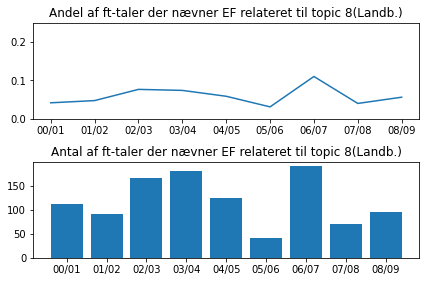

In [53]:
landbrug_taler_år = [Alle_taler_år[i] for i in topics_landbrug]
landbrug_antal_taler_2000_eren = []

for år in år_2000erne:
    landbrug_antal_taler_2000_eren.append(landbrug_taler_år.count(år))
landbrug_andel = [landbrug_antal_taler_2000_eren[i]/antal_taler_år[i] for i in range(9)]
fig, (ax1, ax2) = plt.subplots(2, 1)
ax1.set_title("Andel af ft-taler der nævner EF relateret til topic 8(Landb.)")
ax1.plot(folketingsår, landbrug_andel)
ax1.set_ylim([0, 0.25])
ax2.set_title("Antal af ft-taler der nævner EF relateret til topic 8(Landb.)")
ax2.bar(folketingsår, landbrug_antal_taler_2000_eren)
fig.tight_layout(pad=1.0)
#fig.savefig("plots/2000_erne/Andel_af_folketingstaler_der_nævner_EF relateret_til_topic_8")
#ax.plot(år_1980erne, landbrug_andel)

In [54]:
topics_landbrug_2006 = [i for i in topics_landbrug if Alle_taler_år[i] == "2006"]
topics_landbrug_2006_sand = [topics_landbrug_sand[topics_landbrug.index(i)] for i in topics_landbrug if Alle_taler_år[i] == "2006"]

In [81]:
len(topics_landbrug_2006)

191

In [85]:
topics_landbrug_2006_sand_til_r = [sand for sand in topics_landbrug_2006_sand]
topics_landbrug_2006_sand_til_r.sort(reverse = True)

In [94]:
Alle_taler[topics_landbrug_2006[topics_landbrug_2006_sand.index(topics_landbrug_2006_sand_til_r[7])]]

" Nu kan jeg forstå det yderligere meget subtile, at nu inddrager vi et hvilket som helst hjørne af noget, der ville kunne kaldes landbrug! Det, vi holder os til, er landbruget; det, vi holder os til, er lovforslaget; det, vi holder os til, er begrundelserne i lovforslaget: at som led i EU's landbrugsreform er det direkte EU-tilskud til landbruget i 2005 og 2006 blevet reduceret. Det er forkert. Det var hr. Christian Wedell-Neergaard så redelig at lægge til grund for sine spørgsmål, men jeg vil sige, at indenrigsministeren benægter det i sine besvarelser. Jeg kunne virkelig unde en større del af befolkningen at læse de besvarelser. De ville føle sig hensat til et eller andet meget, meget mærkeligt. Jeg kan forstå, at hr. Jens Kirk slet ikke føler sig hensat til det, han er der bare på stedet. Landbruget har fået flere milliarder kroner ekstra, og for at nyde den forfærdelige smerte skal de have en kompensation. Det er uforståeligt for enhver anden end en, der er i landbruget."

### Topic 2 udenrigpolitik og udvidelse af EU

In [55]:
topics_UP = []
topics_UP_sand = []
for index in range(len(data_lemmatized)):
    bow = gensim_dictionary.doc2bow(data_lemmatized[index])
    eu_tale_topic_distribution = lda_model.get_document_topics(bow)
    for topic, sand in eu_tale_topic_distribution:
        if topic == 2:
            topics_UP.append(index)
            topics_UP_sand.append(sand)
len(topics_UP)

1658

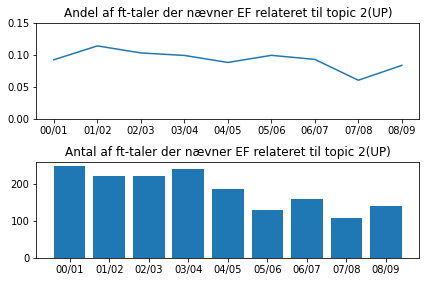

In [58]:
UP_taler_år = [Alle_taler_år[i] for i in topics_UP]
UP_antal_taler_2000_eren = []

for år in år_2000erne:
    UP_antal_taler_2000_eren.append(UP_taler_år.count(år))
UP_andel = [UP_antal_taler_2000_eren[i]/antal_taler_år[i] for i in range(9)]
fig, (ax1, ax2) = plt.subplots(2, 1)
ax1.set_title("Andel af ft-taler der nævner EF relateret til topic 2(UP)")
ax1.plot(folketingsår, UP_andel)
ax1.set_ylim([0, 0.15])
ax2.set_title("Antal af ft-taler der nævner EF relateret til topic 2(UP)")
ax2.bar(folketingsår, UP_antal_taler_2000_eren)
fig.tight_layout(pad=1.0)
#fig.savefig("plots/2000_erne/Andel_af_folketingstaler_der_nævner_EF relateret_til_topic_8")
#ax.plot(år_1980erne, landbrug_andel)